# Assignment 2  
Mohammad Rashiqul Alam  
malam25@illinois.edu  

In [1]:
# Modules
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from   PIL import Image
from scipy.ndimage import gaussian_filter, gaussian_laplace


## Image Pre-Processing

### Import All Images
Import low-resolution images from ~/data/  
Import high-resolution images from ~/data_hires/

**Notebook assumes both data and data_hires directories are in the same level as the notebook!

In [2]:
# Remove borders
def remove_borders(channel, border_percent):
    height, width = channel.shape
    bh = int(height * border_percent)
    bw = int(width * border_percent)
    return channel[bh:height-bh, bw:width-bw]

def load_and_split_image(directory, filename, hires=False, border_percent=0.08):
    """
    Load an image, normalize, split into top/middle/bottom, and remove borders.
    Args:
        directory (str): Directory path.
        filename (str): Image filename.
        hires (bool): True for high-res (.tif), False for low-res (.jpg).
        border_percent (float): Border percentage to crop.
    Returns:
        (top, middle, bottom): Cropped slices as numpy arrays.
    """

    # Load image and normalize
    path = os.path.join(directory, filename)
    image = Image.open(path)
    if hires:
        image_array = np.array(image) / 65535.0
    else:
        image = image.convert('L')
        image_array = np.array(image) / 255.0

    # Split into slices
    h = image_array.shape[0]
    h_per = h // 3
    top    = image_array[0 : h_per, :]
    middle = image_array[h_per : 2*h_per, :]
    bottom = image_array[2*h_per : 3*h_per, :]

    top    = remove_borders(top, border_percent)
    middle = remove_borders(middle, border_percent)
    bottom = remove_borders(bottom, border_percent)

    return top, middle, bottom

In [3]:
# Define directories
data_dir = os.path.join(os.getcwd(), "data")
data_hires_dir = os.path.join(os.getcwd(), "data_hires")

# List all image files
image_files_low_res = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
image_files_high_res = [f for f in os.listdir(data_hires_dir) if f.endswith('.tif')]

# Extract slices for low-resolution images
low_res_slices = []
for filename in image_files_low_res:
    top, middle, bottom = load_and_split_image(data_dir, filename, hires=False)
    low_res_slices.append((top, middle, bottom))

# Extract slices for high-resolution images
high_res_slices = []
for filename in image_files_high_res:
    top, middle, bottom = load_and_split_image(data_hires_dir, filename, hires=True)
    high_res_slices.append((top, middle, bottom))

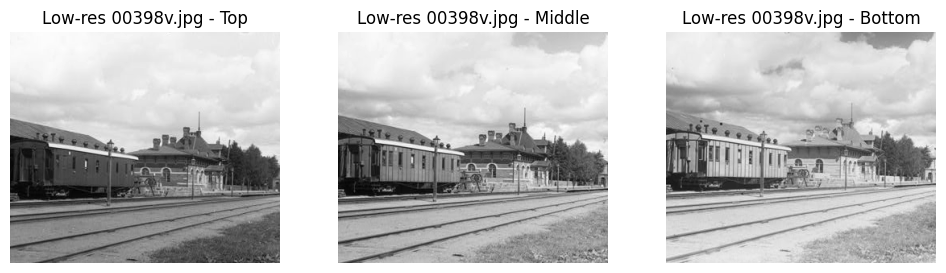

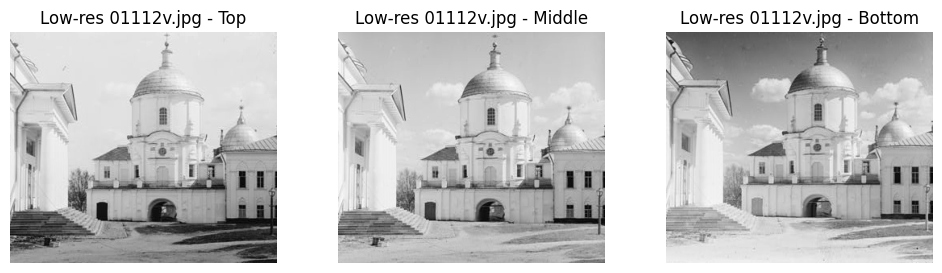

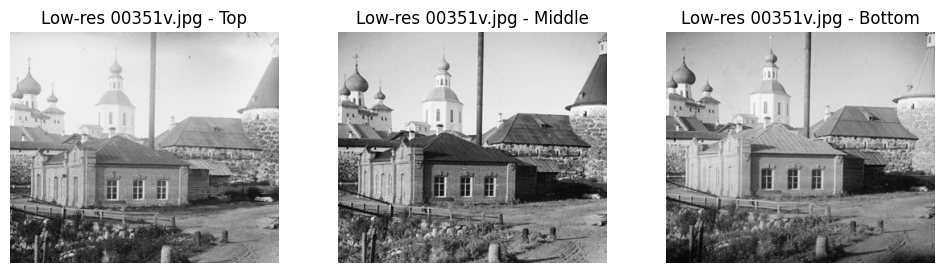

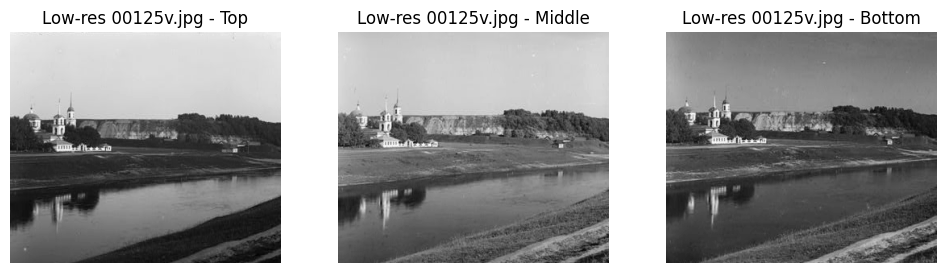

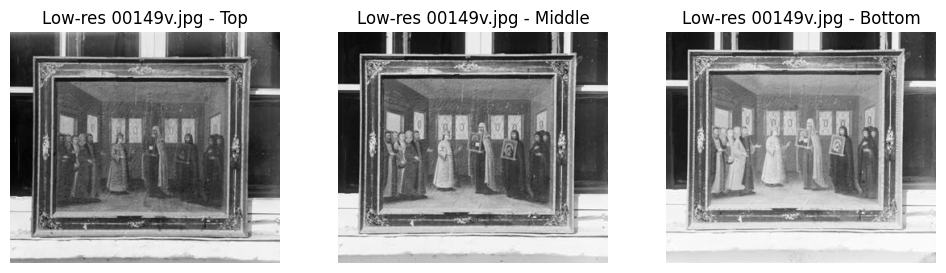

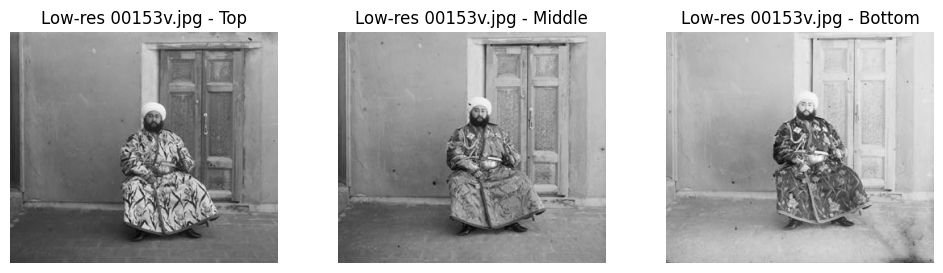

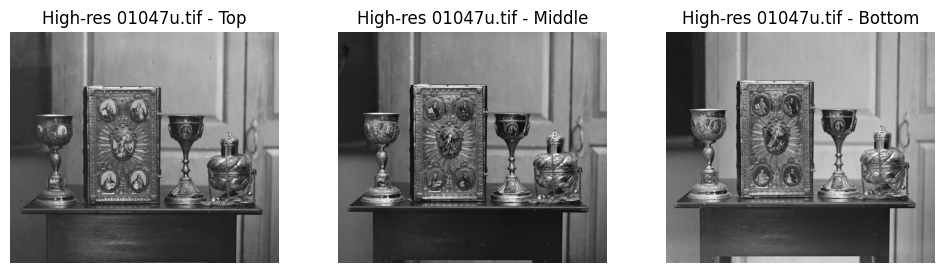

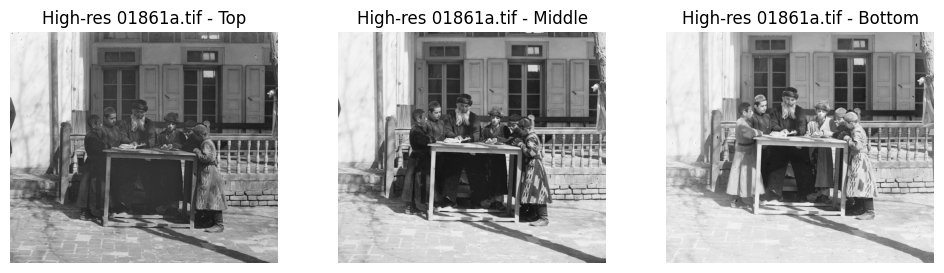

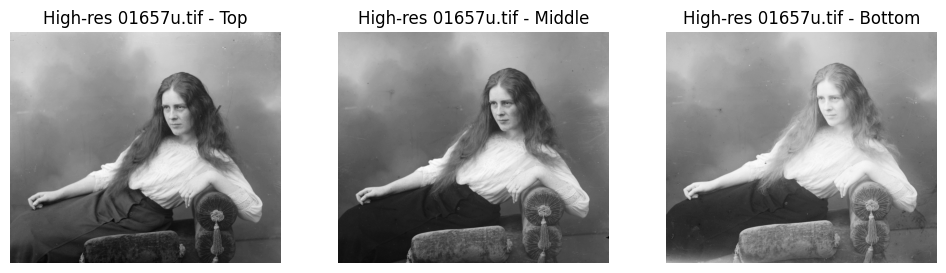

In [4]:
# Plot low-resolution slices next to each other
for i, (top, middle, bottom) in enumerate(low_res_slices):
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(top, cmap='gray')
    plt.title(f'Low-res {image_files_low_res[i]} - Top')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(middle, cmap='gray')
    plt.title(f'Low-res {image_files_low_res[i]} - Middle')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(bottom, cmap='gray')
    plt.title(f'Low-res {image_files_low_res[i]} - Bottom')
    plt.axis('off')
    plt.show()

# Plot high-resolution slices next to each other
for i, (top, middle, bottom) in enumerate(high_res_slices):
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(top, cmap='gray')
    plt.title(f'High-res {image_files_high_res[i]} - Top')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(middle, cmap='gray')
    plt.title(f'High-res {image_files_high_res[i]} - Middle')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(bottom, cmap='gray')
    plt.title(f'High-res {image_files_high_res[i]} - Bottom')
    plt.axis('off')
    plt.show()

### Fast Fourier Transform Alignment Algorithm
- Compute fourier transforms:
    - Take the FFT on the input channels of the image.
    - For e.g. F_base and F_target.
- Form cross-power spectrum:
    - Compute the product of top_FT1 and complex conjugate of bottom_FT2.
- Inverse transform to correlation space.
    - Take the inverse FFT of the above product to obtain the cross-correlation surface.
- Find the displacement:
    - Locate the position of the maximum value in the correlation surface.
    - This position gives the relative shift (offset) between top and bottom channels.
- Align all channels:
    - Using the mid channel as reference base:
        - Align Top -> Mid
        - Align Bottom -> Mid
- Stack aligned channels:
    - Apply the computed offsets to top and bottom, then stack the channels to form the algined color image


In [14]:
# Define the Fourier shift correlation function for finding the displacement between two channels
def fourier_shift_correlation(base, target, visualize_corr=False, title_prefix=""):
    """
    Function that:
     - Computes the Fourier shift correlation between base channel and the target channel.
     - Visualizes the inverse FFT (cross-correlation map).
    Parameters:
        base: The base (reference) channel (2D array).
        target: The target channel (2D array).
        visualize_corr: Flag to visualize the correlation map.
        title_prefix: Title prefix for the visualization.
    Returns:
        The shift in a tuple (dy, dx) needed to align target to base.
    """
    # Ensure inputs are float32 for FFT
    base_f   = base.astype(np.float32, copy=False)
    target_f = target.astype(np.float32, copy=False)

    # Perform fourier transform
    FT1 = np.fft.fft2(base_f)
    FT2 = np.fft.fft2(target_f)

    # Multiply by conjugate
    product = FT1 * np.conjugate(FT2)

    # Inverse FFT
    corr = np.fft.ifft2(product)
    # Compute magnitude
    corr_mag = np.abs(corr)
    
    # Visualization (fftshift ONLY for plotting)
    if visualize_corr:
        plt.figure(figsize=(6,5))
        corr_plot = np.fft.fftshift(corr_mag)
        # Use log scale for better visibility
        corr_plot_log = np.log1p(corr_plot)
        im = plt.imshow(corr_plot_log, cmap='gray', aspect='auto')
        plt.title(f"{title_prefix} Cross-Correlation Map\n(Peak = alignment offset)")
        plt.xlabel("X shift (pixels)")
        plt.ylabel("Y shift (pixels)")
        plt.colorbar(im, label="Correlation magnitude (log scale)")
        plt.tight_layout()
        plt.show()

    # Get the shape of the correlation map
    H, W = corr_mag.shape

    # Find the peak in the correlation map
    # Use np.unravel_index as we need 2D coordinates from the flattened index
    # It returns (row, col) which corresponds to (y, x)
    peak_row, peak_col = np.unravel_index(np.argmax(corr_mag), corr_mag.shape)

    # Compute displacements considering wrap-around
    # Wrap around logic is to handle shifts if greater than half the image size
    dy = peak_row if peak_row <= H // 2 else peak_row - H
    dx = peak_col if peak_col <= W // 2 else peak_col - W
    # Return negative shifts to align target to base
    # The negative sign is because we want to know how much to move the target to align with the base
    return -int(dy), -int(dx)

In [15]:
# Function to align channels and form color images
def align_and_form_color_images(slices_list, visualize_corr=False):
    """
    Function that:
    - Aligns the top and bottom slices to the middle slice.
    - Stacks them into RGB images.
    Parameters:
        slices_list: List of tuples (top, middle, bottom).
        visualize_corr: Flag to visualize correlation maps during alignment.
    Returns:
        color_images: List of aligned RGB images.
        shifts: List of dictionaries with shifts applied for each image.
    """
    color_images = []
    shifts = []
    
    # For each (top, middle, bottom):
    for idx, (top, middle, bottom) in enumerate(slices_list):
        # Find the shift for top relative to middle
        dy_b, dx_b = fourier_shift_correlation(
            middle, top, visualize_corr=visualize_corr, title_prefix=f"#{idx+1} B→G"
        )
        # Find the shift for bottom relative to middle
        dy_r, dx_r = fourier_shift_correlation(
            middle, bottom, visualize_corr=visualize_corr, title_prefix=f"#{idx+1} R→G"
        )

        # Apply the shifts
        # Use np.roll to shift the channels by the computed displacements
        top_aligned    = np.roll(top,    shift=(-dy_b, -dx_b), axis=(0,1))
        bottom_aligned = np.roll(bottom, shift=(-dy_r, -dx_r), axis=(0,1))
        middle_aligned = middle

        # Stack into RGB (bottom=R, middle=G, top=B)
        # From assignment1 we already know the channel order
        rgb = np.dstack([bottom_aligned, middle_aligned, top_aligned])
        # Append the RGB image to the list
        color_images.append(rgb)
        # Append the shifts to the list
        shifts.append({"B->G": (dy_b, dx_b), "R->G": (dy_r, dx_r)})
    # Return the color images and shifts
    return color_images, shifts

### Perform Alginment for Low-Resolution Images 

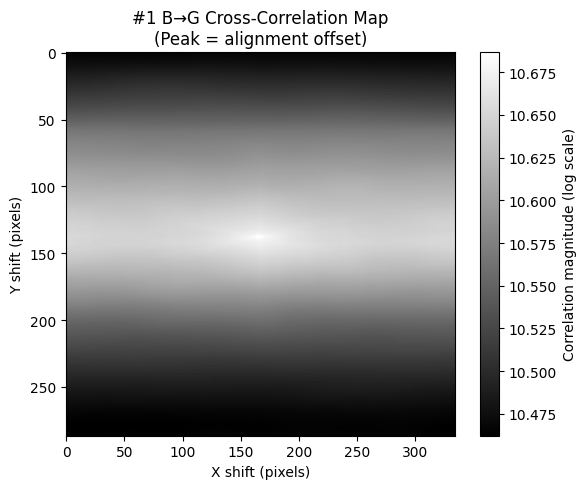

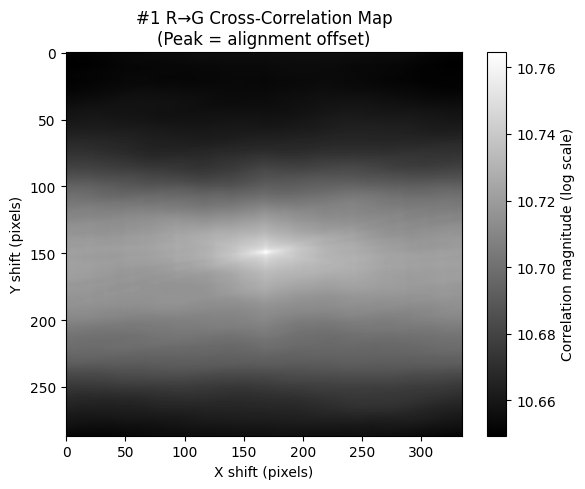

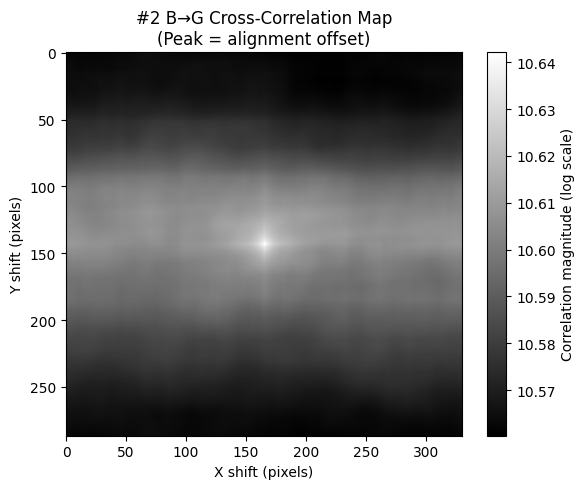

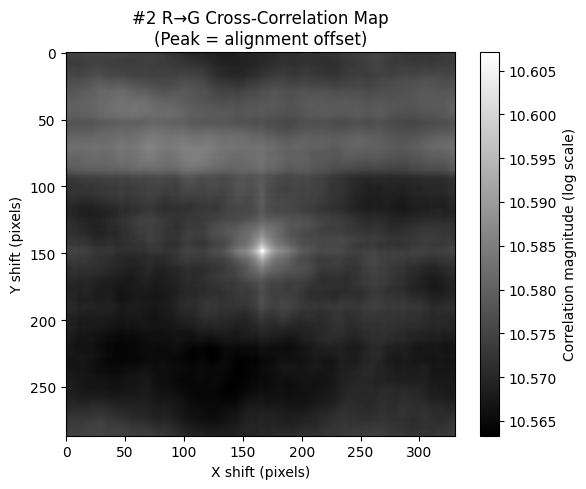

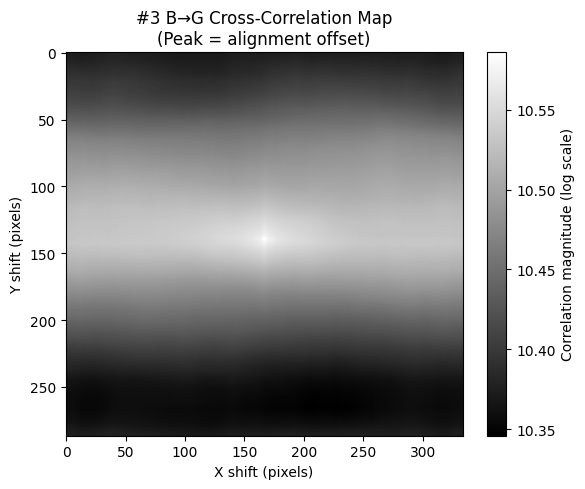

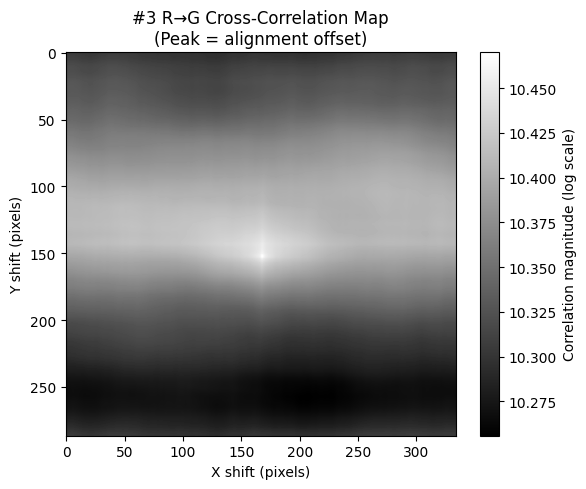

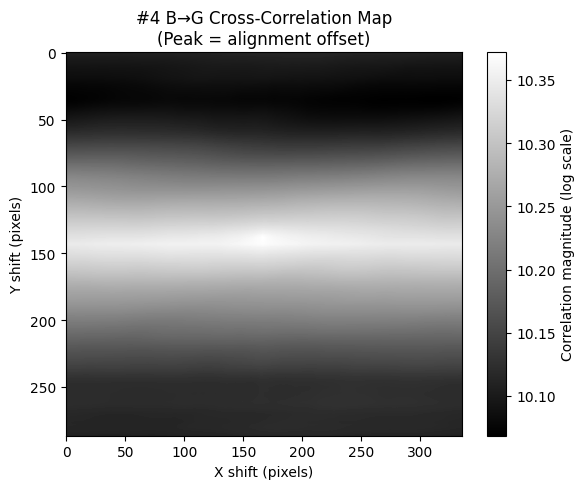

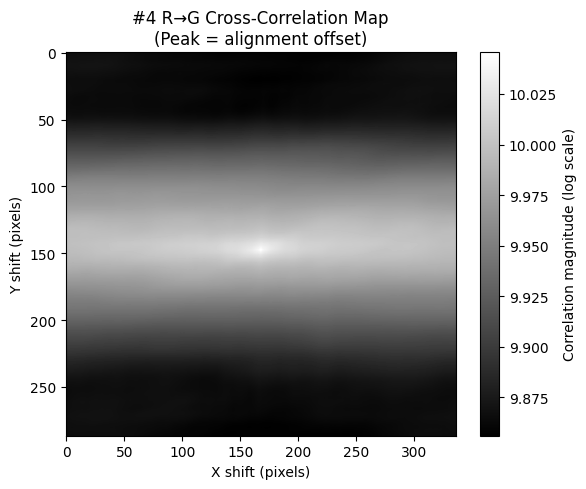

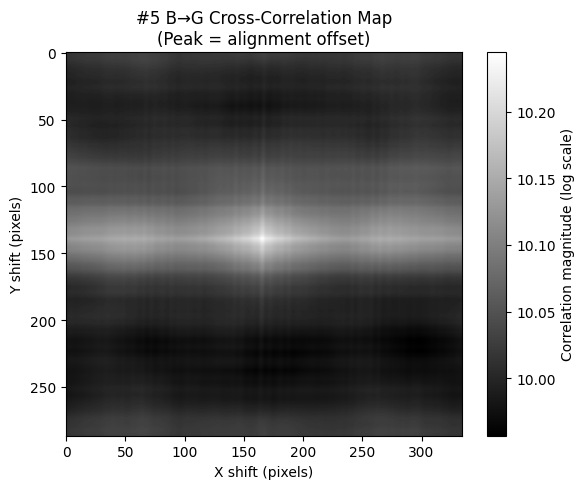

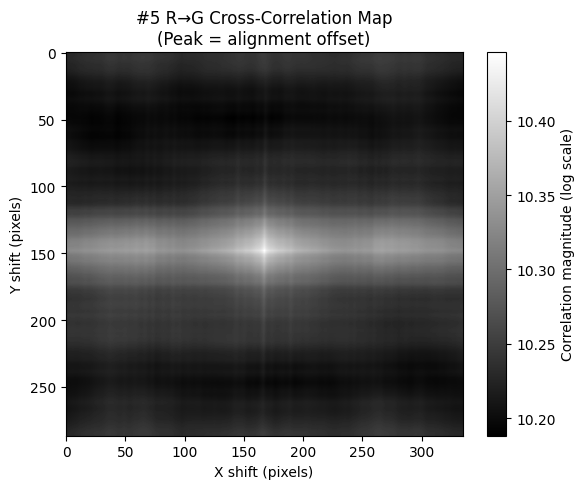

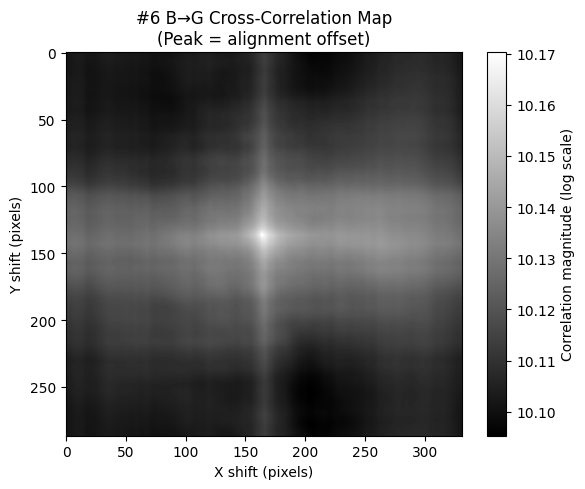

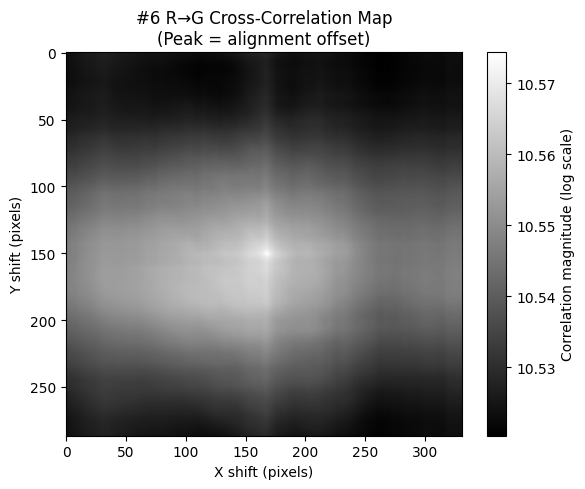

00398v.jpg shifts: {'B->G': (5, 3), 'R->G': (-6, -1)}


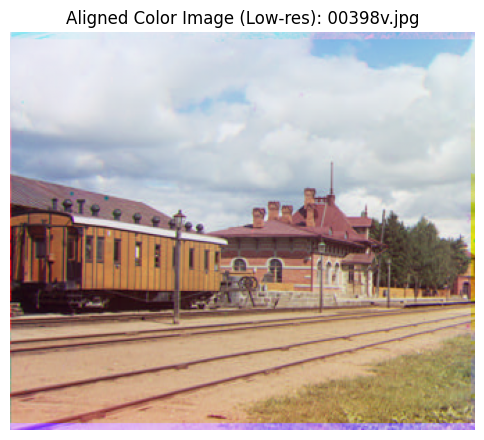

01112v.jpg shifts: {'B->G': (0, 0), 'R->G': (-5, -1)}


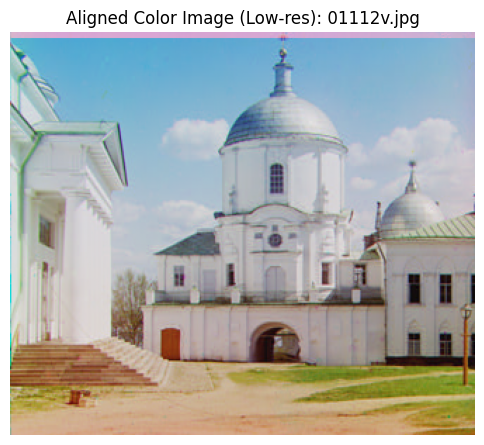

00351v.jpg shifts: {'B->G': (4, 1), 'R->G': (-9, -1)}


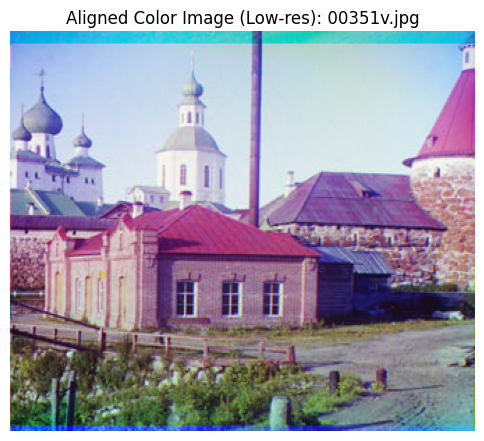

00125v.jpg shifts: {'B->G': (5, 2), 'R->G': (-4, 1)}


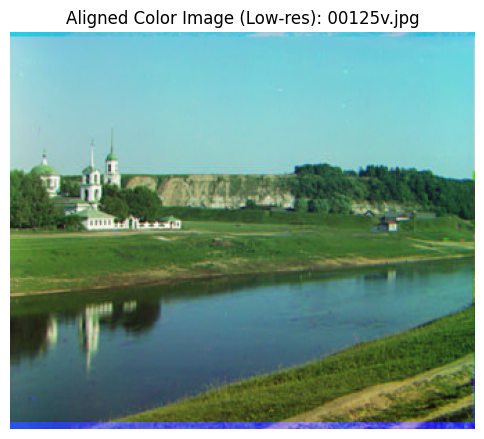

00149v.jpg shifts: {'B->G': (4, 2), 'R->G': (-5, 0)}


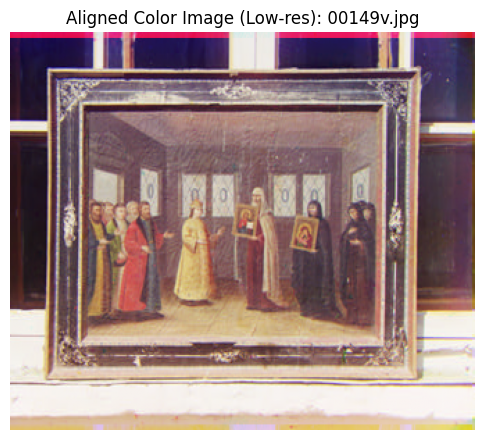

00153v.jpg shifts: {'B->G': (7, 2), 'R->G': (-7, -2)}


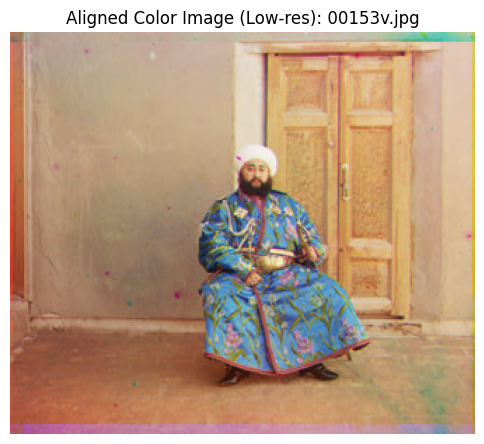

In [ ]:
# Align and form color images for low-resolution images
aligned_low_res_images, low_res_shifts = align_and_form_color_images(
    low_res_slices, visualize_corr=True
)

# Display aligned low-resolution color images and their shifts
for i, color_image in enumerate(aligned_low_res_images):
    plt.figure(figsize=(6,6))
    plt.imshow(color_image)
    plt.title(f"Aligned Color Image (Low-res): {image_files_low_res[i]}")
    plt.axis('off')
    print(f"{image_files_low_res[i]} shifts:", low_res_shifts[i])
    plt.show()

### Perform Alignment for High Resolution Images

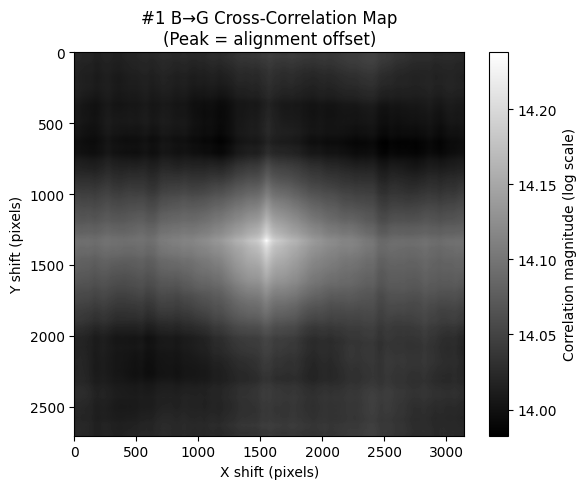

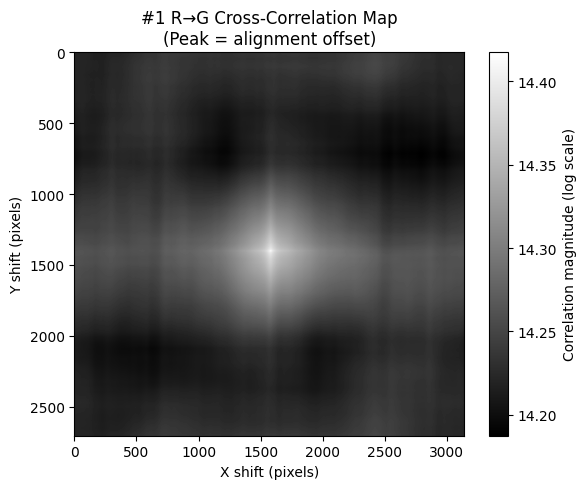

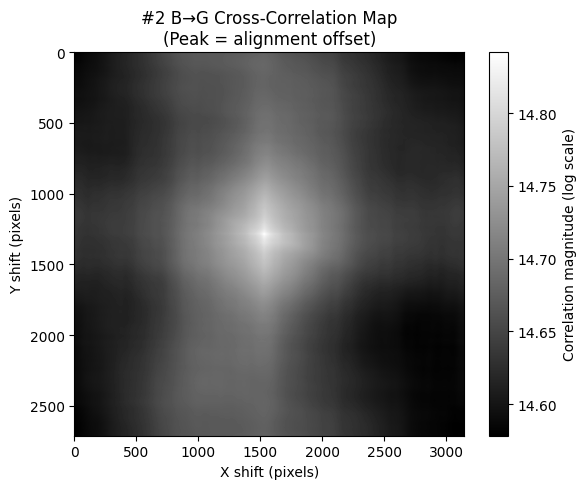

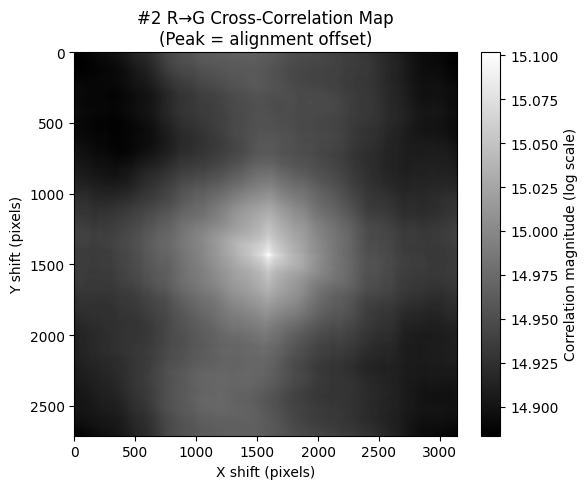

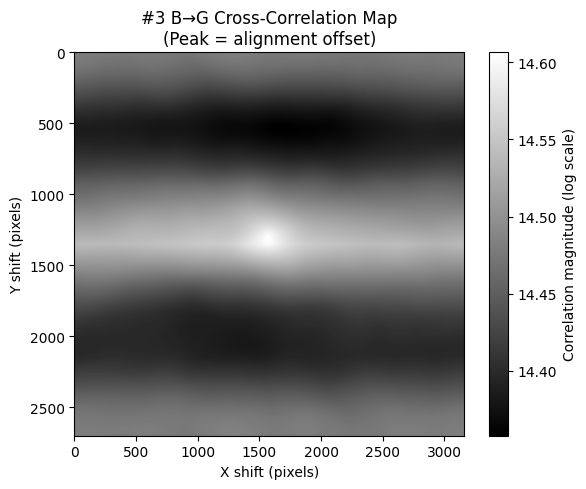

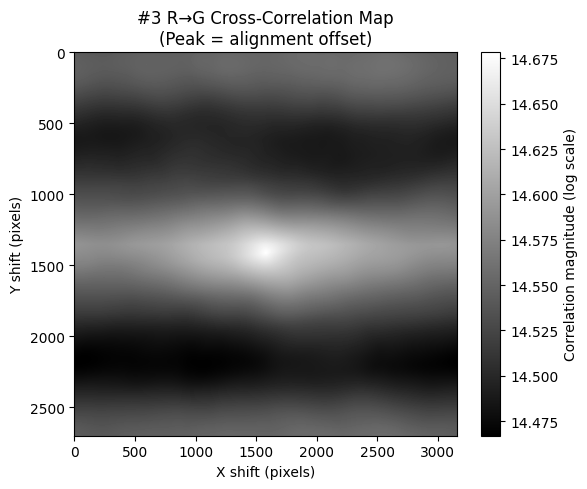

Time taken for high-resolution image alignment: 12.52 seconds
01047u.tif shifts: {'B->G': (24, 20), 'R->G': (-47, -14)}


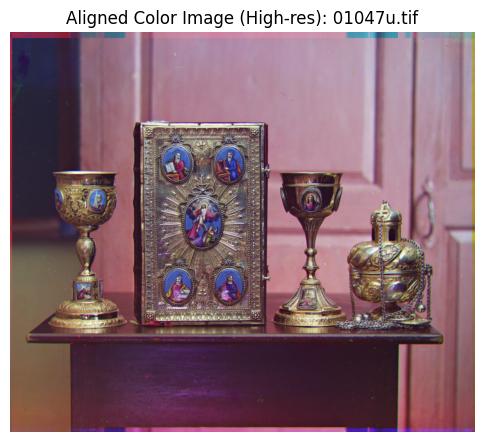

01861a.tif shifts: {'B->G': (71, 39), 'R->G': (-77, -24)}


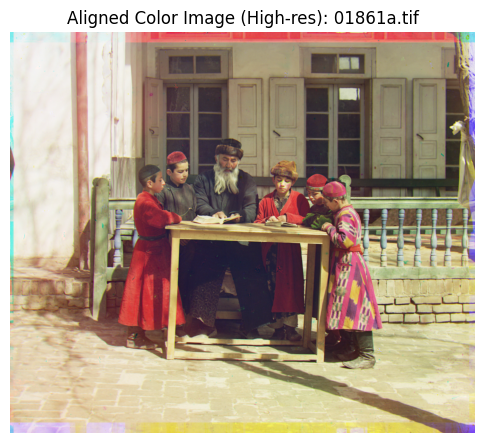

01657u.tif shifts: {'B->G': (49, 9), 'R->G': (-62, -3)}


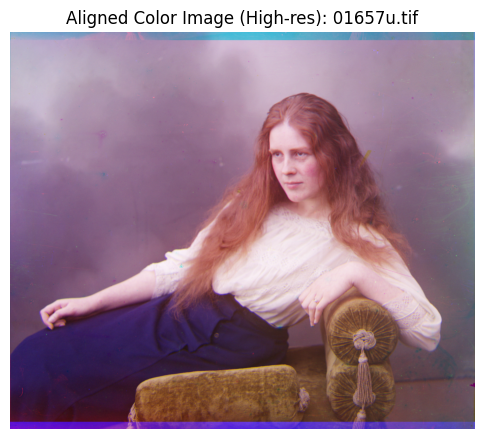

In [18]:
# Measure the time taken for alignment of high-resolution images
start_time = time.time()

# Align and form color images for high-resolution images
aligned_high_res_images, high_res_shifts = align_and_form_color_images(
    high_res_slices, visualize_corr=True
)

end_time = time.time()
print(f"Time taken for high-resolution image alignment: {end_time - start_time:.2f} seconds")

# Display aligned high-resolution color images and their shifts
for i, color_image in enumerate(aligned_high_res_images):
    plt.figure(figsize=(6,6))
    plt.imshow(color_image)
    plt.title(f"Aligned Color Image (High-res): {image_files_high_res[i]}")
    plt.axis('off')
    print(f"{image_files_high_res[i]} shifts:", high_res_shifts[i])
    plt.show()

### Color Channel Preprocessing
- There are faulty alignments in the aligned color imaged 
- To adress this issue apply a small Laplacian of Gaussian filter to highlight edges in each color channel

In [8]:
def preprocess_channel(img, mode="log", sigma=1.0, amount=1.0):
    """Assignment-allowed preprocessing: 'log' for Laplacian-of-Gaussian,
       or 'unsharp' for mild sharpening. Returns float32."""
    x = img.astype(np.float32, copy=False)
    if mode == "log":           # edge emphasis
        # LoG can be positive/negative; magnitude works well for correlation
        return np.abs(gaussian_laplace(x, sigma=sigma))
    elif mode == "unsharp":     # x + amount*(x - blur(x))
        blur = gaussian_filter(x, sigma=sigma)
        return x + amount * (x - blur)
    else:
        return x

In [9]:
# Re-define the align_and_form_color_images function to include preprocessing
def align_and_form_color_images_with_preprocessing(
        slices_list, 
        preprocess="log",
        sigma=1.0, 
        visualize_corr=False):
    color_images, shifts_all = [], []
    for i, (top, middle, bottom) in enumerate(slices_list):
        # assignment-allowed preprocessing
        Bp = preprocess_channel(top,    mode=preprocess, sigma=sigma)
        Gp = preprocess_channel(middle, mode=preprocess, sigma=sigma)
        Rp = preprocess_channel(bottom, mode=preprocess, sigma=sigma)

        # correlate G (base) vs B and R (targets)
        dyB, dxB = fourier_shift_correlation(Gp, Bp, visualize_corr=visualize_corr,
                                             title_prefix=f"#{i+1} B→G")
        dyR, dxR = fourier_shift_correlation(Gp, Rp, visualize_corr=visualize_corr,
                                             title_prefix=f"#{i+1} R→G")

        # shift TARGETS by (-dy, -dx)
        B_aligned = np.roll(top,    shift=(-dyB, -dxB), axis=(0,1))
        R_aligned = np.roll(bottom, shift=(-dyR, -dxR), axis=(0,1))
        G_aligned = middle

        rgb = np.dstack([R_aligned, G_aligned, B_aligned])  # [R,G,B]
        color_images.append(rgb)
        shifts_all.append({"B->G": (dyB, dxB), "R->G": (dyR, dxR)})
        print(f"Image {i+1}: B->G {dyB,dxB} | R->G {dyR,dxR}")

    return color_images, shifts_all

### Color Image Alginment for Low-Resolution Images

Image 1: B->G (5, 3) | R->G (-6, -1)
Image 2: B->G (0, 0) | R->G (-5, -1)
Image 3: B->G (4, 1) | R->G (-9, -1)
Image 4: B->G (5, 2) | R->G (-4, 1)
Image 5: B->G (4, 2) | R->G (-5, 0)
Image 6: B->G (7, 2) | R->G (-7, -2)
00398v.jpg shifts: {'B->G': (5, 3), 'R->G': (-6, -1)}


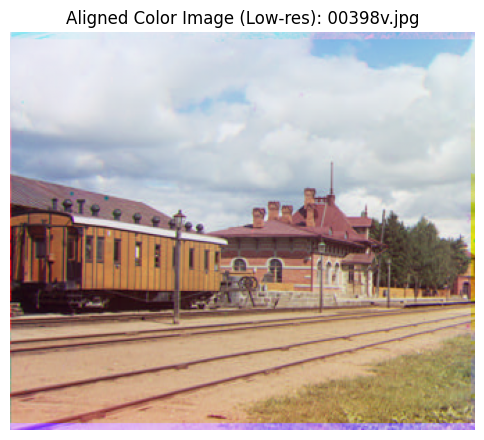

01112v.jpg shifts: {'B->G': (0, 0), 'R->G': (-5, -1)}


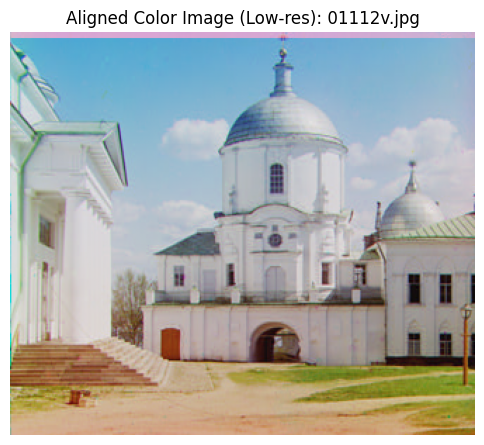

00351v.jpg shifts: {'B->G': (4, 1), 'R->G': (-9, -1)}


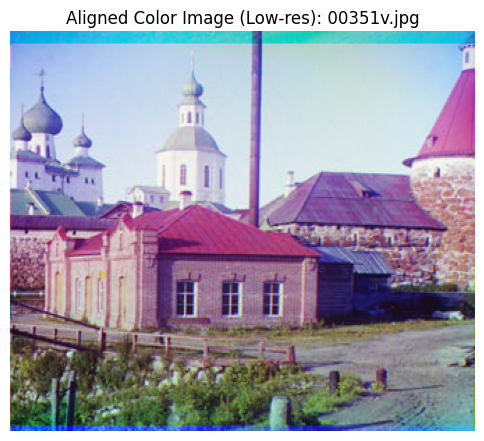

00125v.jpg shifts: {'B->G': (5, 2), 'R->G': (-4, 1)}


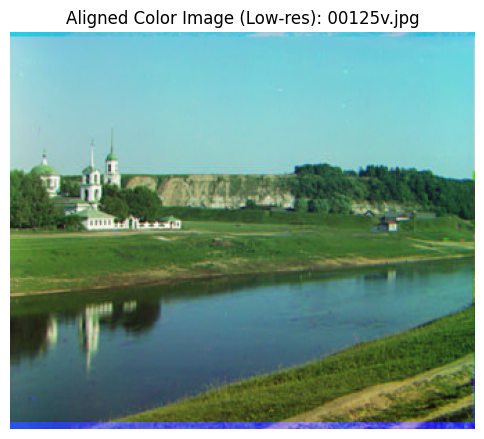

00149v.jpg shifts: {'B->G': (4, 2), 'R->G': (-5, 0)}


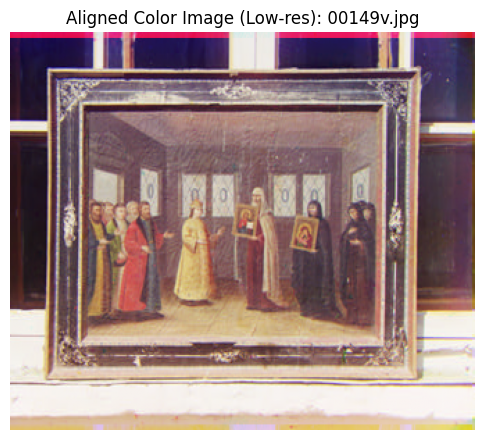

00153v.jpg shifts: {'B->G': (7, 2), 'R->G': (-7, -2)}


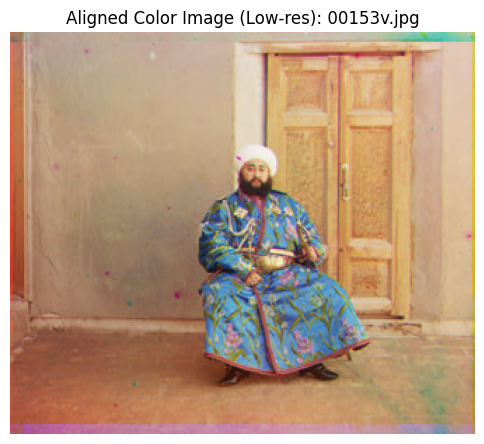

In [10]:
# Align and form color images for low-res images with preprocessing
aligned_low_res_images, low_res_shifts = align_and_form_color_images_with_preprocessing(
    low_res_slices,
    preprocess="gaussian",    
    sigma=1.0,
    visualize_corr=False
)

for i, color_image in enumerate(aligned_low_res_images):
    plt.figure(figsize=(6,6))
    plt.imshow(color_image)
    plt.title(f'Aligned Color Image (Low-res): {image_files_low_res[i]}')
    plt.axis('off')
    print(f'{image_files_low_res[i]} shifts:', low_res_shifts[i])
    plt.show()